In [1]:
import numpy as np
import networkx as nx
import som_functions as som
import math
import sklearn.metrics as met
import sklearn.manifold as man
from time import time
import matplotlib.pyplot as plt

##visualise network
def visualise(G, network, layer):
    
    ##randomly generate colours for plotting
    colours = np.random.rand(len(network), 3)
    
    ##visualise in ghsom function
    som.visualise_graph(G, colours, layer)
    som.visualise_network(network, colours, layer)
    
    for i in network.nodes():
        
        #unpack
        l = network.node[i]['ls']
        n = network.node[i]['n']
        
        if len(n) > 0:

            H = G.subgraph(l)

            visualise(H, n, layer + 1)

##function to recursively label nodes in graph
def label_graph(G, network, layer, neuron_count):
    
    for i in network.nodes():
        
        #unpack
        l = network.node[i]['ls']
        
        ##every node in this neurons receptive field
        for node in l:
            G.node[node]['community'+str(layer)] = neuron_count[layer]
            
        n = network.node[i]['n']
            
        if len(n) > 0: 
            
            label_graph(G, n, layer + 1, neuron_count)
            
        neuron_count[layer] += 1

##function to read in attributes from file and return a dictionary
def read_attributes(filepath):
    
    #initialise dictionary
    d = {}
    
    #open file
    with open(filepath) as f:
        
        #iterate over lines in f
        for l in f:
            
            #separate into key and value
            k, v = l.split()
            
            #add to dictionary
            d[k] = v
    
    #return
    return d

##function to generate benchmark graph
def benchmark_graph(edge_path, c_path):
    
    #construct graph from edge list
    G = nx.read_edgelist(edge_path)

    #create dictionarys of attributes
    c = read_attributes(c_path)

    #set attributes of G
    nx.set_node_attributes(G, 'firstlevelcommunity', c)
    
    #return graph
    return G

##function to generate benchmark graph
def benchmark_hierarchical_graph(edge_path, c1_path, c2_path):

    #construct graph from edge list
    G = nx.read_edgelist(edge_path)

    #create dictionarys of attributes
    c1 = read_attributes(c1_path)
    c2 = read_attributes(c2_path)

    #set attributes of G
    nx.set_node_attributes(G, 'firstlevelcommunity', c1)
    nx.set_node_attributes(G, 'secondlevelcommunity', c2)
    
    #return graph
    return G


def unassign_all_nodes(G, labels):

    #number of layers of communities
    num_layers = len(labels)

    for l in range(num_layers):

        nx.set_node_attributes(G, 'community'+str(l), 'unassigned')

##function to calculate community detection error given a generated benchmark graph
def mutual_information(G, labels):
    
    #number of layers of communities
    num_layers = len(labels)
    
    #initialise scores
    scores = np.zeros(num_layers)
    
    #iterate over all levels of labels
    for i in range(num_layers):
    
        #assigned first layer community
        actual_community = nx.get_node_attributes(G, labels[num_layers - i - 1])

        #predicted first layer community
        predicted_community = nx.get_node_attributes(G, 'community'+str(i + 1))

        #only retrieve labels for assigned nodes
        labels_true = [v for k,v in actual_community.items() if k in predicted_community]
        labels_pred = [v for k,v in predicted_community.items() if k in actual_community]
        
        if len(labels_pred) == 0:
            continue
            
        print (labels_true)
        print (labels_pred)  
            
        #mutual information to score classifcation -- scale by number of assigned nodes out of all nodes
        score = met.normalized_mutual_info_score(labels_true, labels_pred) * len(labels_pred) / len(actual_community)
        scores[i] = score
    
    #return
    return scores 

##function to return all connected components
def connected_components(G):
    
    #number of nodes in the graph
    n = nx.number_of_nodes(G)
    
    #adjacency matrix
    A = nx.adjacency_matrix(G).toarray()
    
    #list of degrees
    deg = np.sum(A, axis=1)
    
    #normalised graph laplacian
    N = np.identity(n) - np.diag(deg ** -0.5) @ A @ np.diag(deg ** -0.5)
    
    #eigen decompose normalised laplacian
    l, U = np.linalg.eigh(N)
    
    ##sort eigenvalues (and eigenvectors) into ascending order
    idx = l.argsort()
    l = l[idx]
    U = U[:,idx]
    
    connected_components = len(l[l<1e-12])
    
    connected_graphs = []
    
    for i in range(connected_components):
        
        ids = U[:,i].nonzero()[0]
        
        H = G.subgraph([G.nodes()[n] for n in ids])
        nx.set_node_attributes(H, 'connected_component', i)
        
        connected_graphs.append(H)
        
    return connected_graphs

##floyds embedding
def floyd_embedding(G):
    
    n = len(G)
    
    fl = nx.floyd_warshall(G)
    
    #intitialise distance matrix
    D = np.zeros((n, n))
    
    for i in range(n):
        n1 = G.nodes()[i]
        for j in range(n):
            n2 = G.nodes()[j]
            D[i,j] = fl[n1][n2]
    
    #centring matrix
    C = np.identity(n) - np.ones((n, n)) / n
    
    #similarity matrix
    K = - 1/2 * C @ D ** 2 @ C
    
    #eigen decompose K
    l, U = np.linalg.eigh(K)
    
    ##sort eigenvalues (and eigenvectors) into ascending order
    idx = l.argsort()[::-1]
    l = l[idx]
    U = U[:,idx]
    
    s = sum(l)
    
    k = len(l)
    var = 1
    
    while var > 0.95:
        k -= 1
        var = sum(l[:k]) / s
    
    k += 1
    print('number of dimensions',k)
    
    #position matrix
    X = U[:,:k] @ np.diag(l[:k] ** 0.5)
    
    return X

##save embedding to graph
def set_embedding(G, X):
    
    #get number of niodes in the graph
    num_nodes = nx.number_of_nodes(G)
    
    #dimension of embedding
    d = len(X[0])
    
    #iterate over a;; the nodes and save their embedding
    for i in range(num_nodes):
        for j in range(d):
            G.node[G.nodes()[i]]['embedding'+str(j)] = X[i,j]    

## get embedding
def get_embedding(G):
    
    #get number of niodes in the graph
    num_nodes = nx.number_of_nodes(G)
    
    #dimension of embedding
    d = 0
    
    while 'embedding'+str(d) in G.node[G.nodes()[0]]:
        d += 1
    
    #initialise embedding
    X = np.zeros((num_nodes, d))
    
    for i in range(num_nodes):
        for j in range(d):
            X[i,j] = G.node[G.nodes()[i]]['embedding'+str(j)]

    return X

def write_layout_file(G, label, filename):
    
    with open('{}.layout'.format(filename), 'w') as f:
        
        for e in G.edges_iter():
            f.write('\"{}\"\t\"{}\"\n'.format(e[0], e[1])) 

        for n in G.nodes():
            if label in G.node[n]:
                f.write('//NODECLASS\t\"{}\"\t\"{}\"\n'.format(n, G.node[n][label]))

##GHSOM algorithm

#H: graph
#lam: lambda -- the number of epochs to train before assessing error
#eta: learning rate
#sigma: initial neighbourhood range
#e_0: error of previous layer
#e_sg: error must reduce by this much for growth to stop
#e_en: error must be greater than this to expand neuron
#layer: layer of som
#n: desired initial number of neurons
#m: desired number of neurons in the next layer
def ghsom(G, lam, w, eta, sigma, e_0, e_sg, e_en, layer, n, m):

    #get embedding of current subgraph
    X = get_embedding(G)

    #number of nodes in G
    num_nodes = nx.number_of_nodes(G)
    
    ##number of training patterns to visit
    N = min(num_nodes, 100)
    
    #create som for this neuron
    network = som.initialise_network(X, n, w)
    
    ##inital training phase
    
    #train for lam epochs
    som.train_network(X, network, lam, eta, sigma, N)

    #classify nodes
    som.assign_nodes(G, X, network, layer)

    #calculate mean network error
    MQE = som.update_errors(network)
    
    ##som growth phase
    #repeat until error is low enough
    while MQE > e_sg * e_0:

        #previous MQE
        prev_MQE = MQE
    
        #find neuron with greatest error
        error_unit = som.identify_error_unit(network)
        
        #expand network
        som.expand_network(network, error_unit)
        
        #train for l epochs
        som.train_network(X, network, lam, eta, sigma, N)

        #classify nodes
        som.assign_nodes(G, X, network, layer)

        #calculate mean network error
        MQE = som.update_errors(network)
        
        print('ghsom has expanded som',layer,'error',MQE)
        
        if np.linalg.norm(MQE - prev_MQE) < 1e-3:
            
            print('no improvement, stopping growth')
            
            break
        
    print('ghsom has terminated expansion',layer)
    print('error',MQE)
    
    #recalculate error after neuron expansion
    MQE = 0
    
    ##neuron expansion phase
    #iterate thorugh all neruons and find neurons with error great enough to expand
    for i in network.nodes():
        
        #unpack
        ls = network.node[i]['ls']
        e = network.node[i]['e']
        
        #check error
        if e > e_en * e_0 and layer < len(labels) or e_0 == math.inf:
#         if layer < len(labels) and len(ls) > 0:

            if e_0 == math.inf:
                e_n = e
            else:
                e_n = e_0
    
            #subgraph
            H = G.subgraph(ls)
            
            #recursively run algorithm to create new network for subgraph of this neurons nodes
            net, e = ghsom(H, lam, w, eta, sigma, e_n, e_sg, e_en, layer + 1, m, m)
            
            #repack
            network.node[i]['e'] = e
            network.node[i]['n'] = net
            
            print('ghsom has built new layer',layer+1)
            
        #increase overall network error
        MQE += e
    
    #mean MQE
    MQE /= nx.number_of_nodes(network)
    
    #return network
    return network, MQE

In [9]:
# generate graph
# G = nx.karate_club_graph()
# G = nx.read_gml('football.gml')
G = nx.read_gml('dolphins_labelled.gml')
# G = benchmark_graph('bin_network.dat', 'community.dat')
# G = benchmark_hierarchical_graph('network.dat', 
#                                  'community_first_level.dat', 
#                                  'community_second_level.dat')
# G = benchmark_hierarchical_graph('literature_network.dat', 
#                                  'literature_community_first_level.dat', 
#                                  'literature_community_second_level.dat')
# G = benchmark_hierarchical_graph('literature_network_32.dat', 
#                                  'literature_community_first_level_32.dat', 
#                                  'literature_community_second_level_32.dat')
# G = benchmark_hierarchical_graph('literature_network_double.dat', 
#                                  'literature_community_first_level_double.dat', 
#                                  'literature_community_second_level_double.dat')
# G = benchmark_hierarchical_graph('rand_network.dat', 
#                                  'rand_community_first_level.dat', 
#                                  'rand_community_second_level.dat')
# G = benchmark_hierarchical_graph('1000network.dat', 
#                                  '1000community_first_level.dat', 
#                                  '1000community_second_level.dat')


print('loaded G',len(G),'nodes')

labels = ['group']
# labels = ['club']
# labels = ['value']
# labels = ['firstlevelcommunity']
# labels = ['firstlevelcommunity','secondlevelcommunity']

#divide graph into connected components
connected_graphs = connected_components(G)
print('calculated number of connected components:',len(connected_graphs))

for H in connected_graphs:
    
    #embedding
    X = floyd_embedding(H)

    #save embedding to graph
    set_embedding(H, X)
    print('embedded graph')
    
##save embedding to gml file
# nx.write_gml(G, 'embedded_karate.gml')
# print ('written gml')

# nx.write_edgelist(G, 'embedded_karate_edgelist.txt', data=False)
# print ('written edgelist')

loaded G 62 nodes
calculated number of connected components: 1
number of dimensions 5
embedded graph


In [2]:
G = nx.read_gml('embedded_football.gml')
labels = ['value']

##start time
start = time()

#number of epochs to train == lambda
lam = 1000

#weights are initialised based on a uniform random distribution between +- this value
w = 0.066269

#initial learning rate
eta_0 = 0.058690

#initial neighbourhood size
sigma_0 = 1.00

#stop growth of current layer (relative to MQE0)
e_sg = 0.450884

#error must be greater than this times MQE0
e_en = 0.3

#layer of GHSOM
layer = 0;

#desired number of initial neurons
n = 1

#desired number of initial neurons for all other layers
m = 1

#scores array
mi_scores = np.array([])

#number of connected components in graph
comps = nx.get_node_attributes(G,'connected_component')

for i in range(max(list(comps.values())) + 1):
    
    H = G.subgraph([k for k,v in comps.items() if v == i])

    #run ghsom algorithm
    network, MQE = ghsom(H, lam, w, eta_0, sigma_0, math.inf, e_sg, e_en, layer, n, m)

    print('ghsom algorithm has terminated')
    print('mean network error:',MQE)

    #label graph
    unassign_all_nodes(G, labels)
    neurons = np.zeros(len(labels) + 1, dtype=np.int)
    label_graph(H, network, 0, neurons)
    
    ##visualise
    visualise(H, network, 0)
    
    ##calculate error
    mi_score = mutual_information(H, labels)
    print('normalised mutual information score',mi_score)
    
    mi_scores = np.append(mi_scores, mi_score)
    
print('mean mi score over all connected components',np.mean(mi_scores))
    
##time taken
print('time taken',(time() - start))

NameError: name 'unichr' is not defined

In [13]:
write_layout_file(G, 'community1', 'layout_football')

<IPython.core.display.Javascript object>


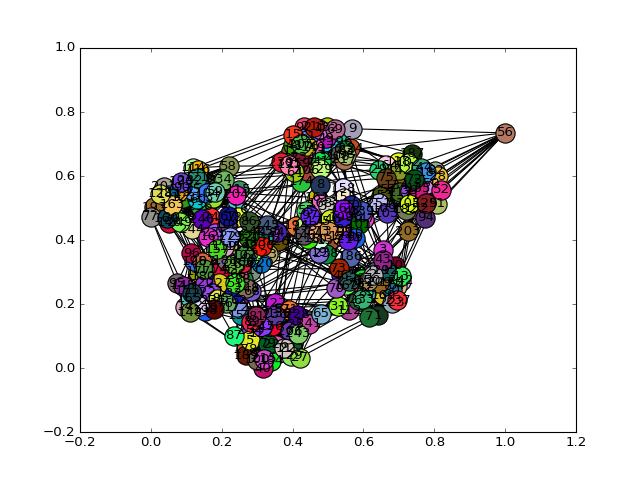

<IPython.core.display.Javascript object>


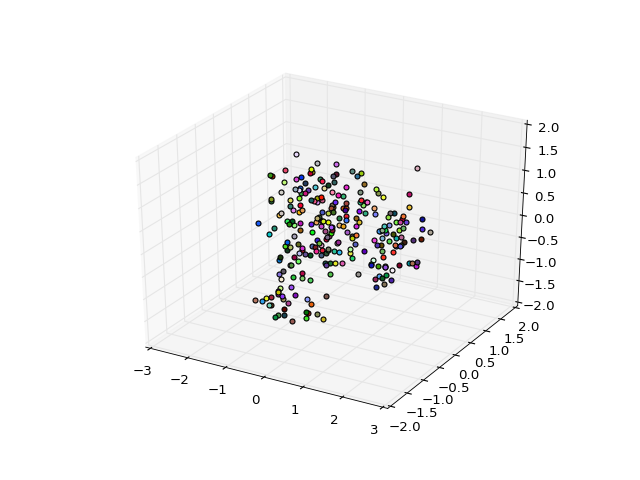

In [10]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colours = np.random.rand(len(G),3)

##create new figure for lattice plot
fig, ax = plt.subplots()

# graph layout
pos = nx.spring_layout(G)

# draw nodes -- colouring by cluster
for i in range(len(G)):
    nx.draw_networkx_nodes(G, pos, nodelist = [G.nodes()[i]], node_color = colours[i])

#draw edges
nx.draw_networkx_edges(G, pos)

# draw labels
nx.draw_networkx_labels(G, pos)


plt.show()



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(G)):
    ax.scatter(X[i,0],X[i,1],X[i,2],c=colours[i])

plt.show()